## 位相周期誤差に対する測位誤差の変化

In [116]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pyomo.environ import *

%matplotlib inline

warnings.simplefilter('ignore')

In [117]:
tag_location = {
    "x": 1,
    "y": 1,
}
tag_population = 2
tags_number = np.arange(tag_population)
tags_space = 0.5
frequency_list = np.array([916.8e6, 918.0e6, 919.2e6, 920.4e6])
light_speed = 2.998e8
wave_length_list = [light_speed/frequency for frequency in frequency_list]

In [118]:
wave_length = wave_length_list[3]
R = np.sqrt((tag_location["x"]+tags_number*tags_space)**2 + tag_location["y"]**2)
phases = (
    (
        -4
        * np.pi
        * R
        / wave_length
    )
    % (2 * np.pi)
)

N = (-R * 4 * np.pi / wave_length) // (2*np.pi)
print(R)
print(phases)
print(N)

[1.41421356 1.80277564]
[1.98923539 5.84832111]
[ -9. -12.]


In [119]:
def trilateration(R1:np.ndarray, R2:np.ndarray):

    x_result = []
    y_result = []

    for i in np.arange(len(R1)):

        x = []
        y = []

        for j in np.arange(len(R2)):

            r1 = R1[5]
            r2 = R2[5]

            print(r1,r2)

            model = ConcreteModel(name=f"{i,j}-trilateration")

            model.x = Var(
                within=Reals, bounds=(-2, 2), initialize=0
            )
            model.y = Var(
                within=Reals, bounds=(0, 2), initialize=1
            )

            def objective_rule(model):
                return ((pow(model.x, 2)+pow(model.y,2))-pow(r1,2) + (pow(model.x+tags_space,2)+pow(model.y, 2))-pow(r2, 2))
            
            model.obj = Objective(
                rule=objective_rule,
                sense=minimize,
            )

            opt = SolverFactory("scip")
            opt.solve(model, tee=False)

            x.append(model.x())
            y.append(model.y())

            print(model.x(), model.y())

        x_result.append(x)
        y_result.append(y)

    x_result = np.array(x_result)
    y_result = np.array(y_result)

    # cos_theta = (np.power(r1,2)+np.power(tags_space,2)-np.power(r2,2))/(2*r1*tags_space)
    # print(cos_theta)
    # theta = np.arccos(cos_theta)
    # x = -r1*cos_theta
    # y = r1*np.sin(theta)

    return (x_result,y_result)

In [120]:
n1_noise = n2_noise = np.arange(-5,6)

r1 = -wave_length/(4*np.pi)*(phases[0]+2*(N[0]+n1_noise)*np.pi)
r2 = -wave_length/(4*np.pi)*(phases[1]+2*(N[1]+n2_noise)*np.pi)

x,y = trilateration(r1, r2)

err = np.sqrt(np.power(tag_location["x"]-x, 2) + np.power(tag_location["y"]-y, 2))

1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213562373095 1.8027756377319946
-0.24999999969461198 0.0
1.414213

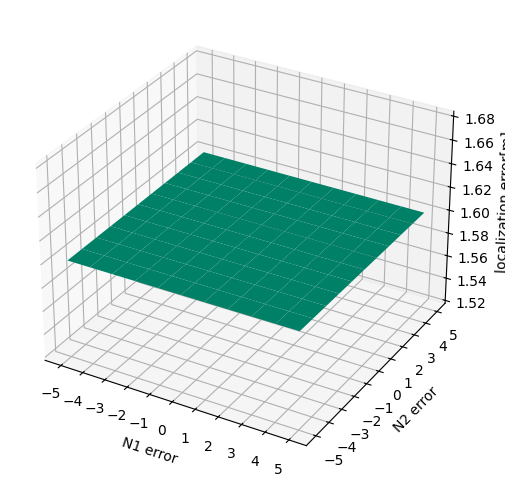

In [121]:
N1, N2 = np.meshgrid(n1_noise, n2_noise)
fig = plt.figure(figsize=(6,10))
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(N1,N2,err, cmap="summer")
ax.contour(N1, N2, err, colors = "black", offset = -1)
ax.set_xticks(n1_noise)
ax.set_yticks(n2_noise)
ax.set_xlabel("N1 error")
ax.set_ylabel("N2 error")
ax.set_zlabel("localization error[m]")
plt.show()